In [1]:
from pathlib import Path

import rasterio
from rasterio.windows import from_bounds
from rasterio.env import Env

import matplotlib.pyplot as plt

#### Subset GeoTIFF given a bounding box

In [53]:
url = Path("https://eks-1-hub.s3.eu-central-1.amazonaws.com/data/data_ard/SENTINEL-2/S2MSI2A/S2B_MSIL2A_20240802T090559_N0511_R050_T34SGF_20240802T103527.SAFE/T34SGF_20240802T090559_B02_10m.tif")
bounds = (528242, 4051961.0, 542624.6681694408, 4071649.0)

with rasterio.Env(AWS_NO_SIGN_REQUEST='YES'):
    with rasterio.open(url) as src:
        window = from_bounds(*bounds, transform=src.transform)
        window_affine = src.window_transform(window)
        
        # Update metadata for the cropped output
        profile = src.profile.copy()
        # Here you update the things that change after the subset. These are the affine matrix and the heigh/width of the subset
        profile.update({
            "height": int(window.height),
            "width": int(window.width),
            "transform": window_affine
        })

        # Read the defined window
        data = src.read(1, window=window)  # You can loop over bands or read multiple if you want
    
        # Write as a new GeoTIFF subset
        # Insert suffix before the file extension
        new_filename = url.stem + "_subset" + url.suffix # Append suffix to filename
        output_tif = Path('/home/data')/url.parent.name/new_filename # create full path to save
        output_tif.parent.mkdir(parents=True, exist_ok=True)
        with rasterio.open(output_tif, "w", **profile) as dst:
            dst.write(data, 1)

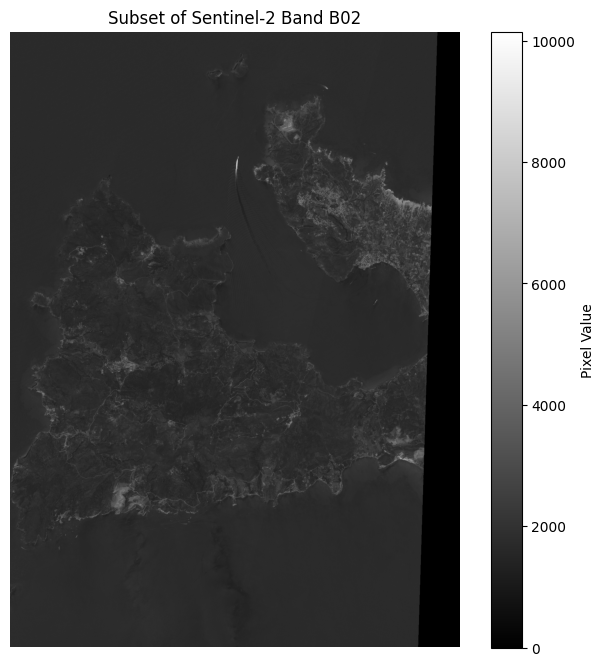

In [37]:
plt.figure(figsize=(8, 8))
plt.imshow(data, cmap='gray')  # Use 'viridis' or other colormaps for variety
plt.colorbar(label='Pixel Value')
plt.title("Subset of Sentinel-2 Band B02")
plt.axis('off')
plt.show()

#### Subset GeoTIFF with an adjusted bounding box based on the patch size of a the U-Net

In [ ]:
url = Path("https://eks-1-hub.s3.eu-central-1.amazonaws.com/data/data_ard/SENTINEL-2/S2MSI2A/S2B_MSIL2A_20240802T090559_N0511_R050_T34SGF_20240802T103527.SAFE/T34SGF_20240802T090559_B02_10m.tif")
bounds = (528242, 4051961.0, 542624.6681694408, 4071649.0)

In [13]:
def get_patch_size_divisible_bounds(affine_transform, original_bounds, patch_size):
    """
    Args:
        affine_transform (affine.Affine)
        original_bounds (tuple)
        patch_size (int)
    
    Returns:
        adjusted_bounds (tuple)
    """
    res_x = affine_transform.a        # pixel size width (e.g., 10.0 m for Sentinel-2)
    res_y = -affine_transform.e       # pixel seize height (make it positive)

    # Calculate desired pixel size of the crop
    width_m = bounds[2] - bounds[0]
    height_m = bounds[3] - bounds[1]

    width_px = int(width_m // res_x)
    height_px = int(height_m // res_y)

    # Adjust to the largest multiple of patch_size
    width_px_adj = (width_px // patch_size) * patch_size
    height_px_adj = (height_px // patch_size) * patch_size

    # Compute adjusted physical width/height
    adj_width_m = width_px_adj * res_x
    adj_height_m = height_px_adj * res_y

    # Adjust right and top to reduce the area (keep origin fixed at bottom-left)
    left, bottom = bounds[0], bounds[1]
    right = left + adj_width_m
    top = bottom + adj_height_m
    
    adjusted_bounds = (left, bottom, right, top)
    
    return adjusted_bounds

In [14]:
patch_size = 96  # Patch size in pixels

with rasterio.Env(AWS_NO_SIGN_REQUEST='YES'):
    with rasterio.open(url) as src:

        affine_transform = src.transform  # Affine transformation

        # Get adjusted bounds
        adjusted_bounds = get_patch_size_divisible_bounds(affine_transform, bounds, patch_size)
        
        # Use adjusted bounds to extract cleanly patchable image
        window = from_bounds(*adjusted_bounds, transform=affine_transform)
        window_affine = src.window_transform(window)
        
        # Update metadata for the cropped output
        profile = src.profile.copy()
        # Here you update the things that change after the subset. These are the affine matrix and the heigh/width of the subset
        profile.update({
            "height": int(window.height),
            "width": int(window.width),
            "transform": window_affine
        })
        
        data = src.read(1, window=window)

        # Write as a new GeoTIFF subset
        # Insert suffix before the file extension
        new_filename = url.stem + "_subset_adjustedbounds2" + url.suffix # Append suffix to filename
        output_tif = Path('/home/data')/url.parent.name/new_filename # create full path to save
        output_tif.parent.mkdir(parents=True, exist_ok=True)
        with rasterio.open(output_tif, "w", **profile) as dst:
            dst.write(data, 1)
            
        print("Adjusted bounds:", adjusted_bounds)
        print("Data shape:", data.shape)  # Should be divisible by patch_size

Adjusted bounds: (528242, 4051961.0, 541682.0, 4071161.0)
Data shape: (1920, 1344)
